In [120]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [121]:
fashion = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion.load_data()

In [122]:
print(x_train[0].shape)
print(x_train.shape)
print(x_test.shape)

(28, 28)
(60000, 28, 28)
(10000, 28, 28)


If we want to reshape a single image : 
img = img.reshape((28, 28, 1))

But, x_train contains batch of 60000 images. So, that dim has also to be passes

The original datatype in most cases is int8 (0-255)

Why convert to float32?
- Older python versions will carry integer division if numerator is integer. But, this is not a problem in newer verions
- NN prefer float datatype rather than int!

In [123]:
x_train = x_train.reshape((60000, 28, 28, 1))    #original shape of x_train = (60000, 28, 28)
# x_train = x_train.reshape((-1, 28, 28, 1)) : It will automatically understand the batch size (60000) of x_train
x_test = x_test.reshape((10000, 28, 28, 1))
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0



In [124]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(10000).batch(128)

In [125]:
print(len(train_dataset))     #128x469 ~ 60000

469


train_dataset.take(n) :
- Take only the first n elements (batches or samples) from the dataset.

In [126]:
for batch in train_dataset.take(1):
    print(batch.shape)

(128, 28, 28, 1)


- padding='same' preserves size only when stride=1
- padding = SAME means that: 
### output_size = ceil(input_size/stride)
- Thus, when stride=1; output_size = input_size.
- the generic output size formula is:

o = floor( (i + p - k) / s)   +   1

In [136]:
def encoder(encoder_input, alpha=0.2, latent_space_dim=16):

    input_encoder = tf.keras.Input(shape = encoder_input, name='encoder_input_layer')

    x = layers.Conv2D(32, kernel_size=3, padding='same', strides=1, name='conv_1')(input_encoder)
    x = layers.BatchNormalization(name='batch_norm_1')(x)
    x = layers.LeakyReLU(alpha=alpha, name='leaky_relu_1')(x)         #(28, 28, 32)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='batch_norm_2')(x)
    x = layers.LeakyReLU(alpha=alpha, name='leaky_relu_2')(x)         #(14, 14, 64)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='batch_norm_3')(x)
    x = layers.LeakyReLU(alpha=alpha, name='leaky_relu_3')(x)        #(7, 7, 64)

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='batch_norm_4')(x)
    x = layers.LeakyReLU(alpha=alpha, name='leaky_relu_4')(x)        #(7, 7, 64)

    flatten = layers.Flatten(name='flatten')(x)            #(7*7*64)
    mean = layers.Dense(latent_space_dim, name='mean')(flatten)
    log_var = layers.Dense(latent_space_dim, name='lag_var')(flatten)

    model = tf.keras.Model(inputs=input_encoder, outputs=(mean, log_var), name="Encoder")

    return model


- The Lambda layer in Keras lets you wrap arbitrary expressions as a Layer object. 
- This creates a layer that applies the reparameterization function to its inputs.
- The inputs of the Lambda layers are passed to the function that was called

In [137]:
def reparameterization(distribution_params):
    mean, log_var = distribution_params
    epsilon = tf.random.normal(shape=tf.shape(mean) , mean=0.0, stddev=1.0)
    z = mean + (tf.exp(log_var/2))*epsilon
    return z
    

In [138]:
def sampling_layer(input_shape1, input_shape2):
    mean = keras.Input(shape=input_shape1, name='mean_input')
    log_var = keras.Input(shape=input_shape2, name='log_var_input')

    z_layer = layers.Lambda(reparameterization, name='sampling_layer')([mean, log_var])

    sampling_model = tf.keras.Model(inputs=[mean, log_var], outputs = z_layer, name='sampling_model')
    return sampling_model


In [139]:
def decoder(input_decoder):
     
    decoder_input = keras.Input(shape=input_decoder, name='decoder_input')
    x = layers.Dense(3136, name='dense_1')(decoder_input)
    x = layers.Reshape((7, 7, 64), name='Reshape_Layer')(x)
    
    # Block-1
    x = layers.Conv2DTranspose(64, kernel_size=3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2DTranspose(64, kernel_size=3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
     
    # Block-3
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
     
    # Block-4
    decoder_output = layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name='conv_transpose_4')(x)

    model = tf.keras.Model(inputs = decoder_input, outputs = decoder_output, name="Decoder")
    return model

In [140]:
import tensorflow as tf
from keras import layers, Model

class VAE(Model):
    def __init__(self, encoder_model, decoder_model, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder_model
        self.decoder = decoder_model

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            mean, log_var = self.encoder(data)
            # Use your reparameterization logic
            z = reparameterization([mean, log_var])
            reconstruction = self.decoder(z)
            # Reconstruction loss (MSE)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=[1,2,3]))
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1))
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        z = reparameterization([mean, log_var])
        return self.decoder(z)

# Instantiate your models using your functions
encoder_model = encoder((28,28,1), latent_space_dim=8)
decoder_model = decoder(8)

# Create and compile the VAE
vae = VAE(encoder_model, decoder_model)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=7,            # Stop after 5 epochs with no improvement
    restore_best_weights=True
)


vae.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stop]
)

Epoch 1/20
469/469 [==============================] - 13s 26ms/step - loss: 35.1674 - reconstruction_loss: 27.9920 - kl_loss: 7.1754 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/20
469/469 [==============================] - 12s 25ms/step - loss: 26.6819 - reconstruction_loss: 19.0174 - kl_loss: 7.6645 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/20
469/469 [==============================] - 12s 25ms/step - loss: 25.8477 - reconstruction_loss: 18.0156 - kl_loss: 7.8321 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/20
469/469 [==============================] - 12s 25ms/step - loss: 25.4211 - reconstruction_loss: 17.4752 - kl_loss: 7.9459 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/20
469/469 [==============================] - 12s 25ms/step - loss: 25.1078 - reconstruction_loss: 17.1033 - kl_

4/4 [==============================] - 0s 3ms/step


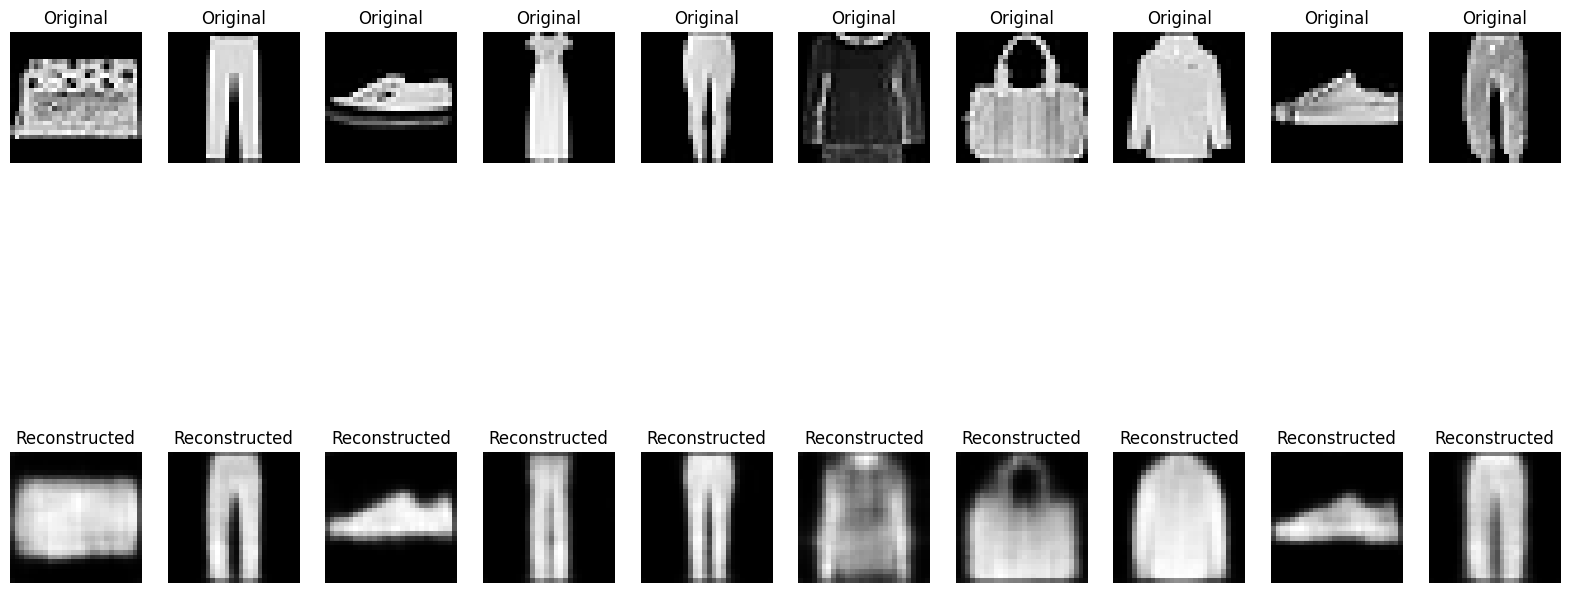

In [141]:
import matplotlib.pyplot as plt

# Get a batch of test images
for test_batch in val_dataset.take(1):
    test_images = test_batch.numpy()
    break

# Generate reconstructions
reconstructed = vae.predict(test_images)

# Plot original and reconstructed images
n = 10  # number of images to display
plt.figure(figsize=(20, 10))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()